In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from pathlib import Path
import yaml
import datetime

In [2]:
# Настроим подключение к базе данных
CONFIG_PATH = "config.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as config_file:
    CONFIG = yaml.load(config_file, Loader=yaml.FullLoader)

CON = create_engine(
    CONFIG['database_url']
)

def select(query: str, con: Engine = CON) -> pd.DataFrame:
    """
    Функция обобщённого sql-запроса к базе данных соцсети, содержащей три таблицы:
    1. Данные пользователей user
    2. Данные постов post
    3. Данные действий пользователей в соцсети feed
    """
    return pd.read_sql(query, con)

### Исследуем таблицу пользователей

In [3]:
# Посмотрим таблицу юзеров
q = """
SELECT *
FROM public.user
"""

user_data = select(q)
user_data.head()

,id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [4]:
user_data.id.nunique(), user_data.shape[0]

(163205, 163205)

In [5]:
user_data.id.min(), user_data.id.max()

(200, 168552)

In [6]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


Получается, что id пользователей принимают значения от 200 до 168552, при этом отсутствует около 5000 id.
Для обработки ситуации с передачей в запрос несуществующего id, добавим в сервис следующее.

In [7]:
# Пусть пришел запрос от пользователя с неизвестным id.
# Воспользуемся следующей логикой - показать что-то лучше, чем выдать ошибку и не показать ничего.
# Тогда пусть для неизвестных id будет выдаваться лента "усредненного пользователя" - 
# виртуального пользователя с наиболее часто встречающимися признаками

mean_user = {
    "gender": user_data.gender.mode().values[0],
    "age": user_data.age.mode().values[0],
    "country": user_data.country.mode().values[0],
    "city": user_data.city.mode().values[0],
    "exp_group": user_data.exp_group.mode().values[0],
    "os": user_data.os.mode().values[0],
    "source": user_data.source.mode().values[0],
}

mean_user

{'gender': 1,
 'age': 20,
 'country': 'Russia',
 'city': 'Moscow',
 'exp_group': 3,
 'os': 'Android',
 'source': 'ads'}

### Теперь таблицу постов


In [8]:
q = """
SELECT *
FROM public.post
"""

post_data = select(q)
post_data.head()

,id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [9]:
post_data.id.nunique(), post_data.shape[0]

(7023, 7023)

In [10]:
post_data.id.min(), post_data.id.max()

(1, 7319)

In [11]:
post_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7023 non-null   int64 
 1   text    7023 non-null   object
 2   topic   7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


Пропусков нет

### Таблица взаимодействия

In [12]:
# Наконец посмотрим на таблицу взаимодействия пользователей и постов в соцсети
q = """
SELECT count(*)
FROM public.feed_data
"""

count_feed_data = select(q)
count_feed_data.head()

,count
0,76892800


In [13]:
# Как видно, в таблице 77 миллионов записей, что превышает наши вычислительные возможности.
# Посмотрим временные рамки всего доступного датасета
q = """
SELECT MIN(timestamp), MAX(timestamp)
FROM public.feed_data
"""

timestamp_limits = select(q)
timestamp_limits

,min,max
0,2021-10-01 06:01:40,2021-12-29 23:51:06


In [14]:
# Отсортируем и пронумеруем все действия юзеров с помощью оконной функции
# и отфильтруем ранние действия юзеров и будем рассматривать только не позднее 35го по счету.
q = """
WITH q1 (timestamp, user_id, post_id, action, target, num) AS 
(
    SELECT timestamp, user_id, post_id, action, target, ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp DESC) AS num
    FROM public.feed_data
    WHERE action = 'view'
)
SELECT timestamp, user_id, post_id, target
FROM q1
WHERE num <= 75
"""

feed_data = select(q)
feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-29 15:24:59,200,1773,0
1,2021-12-29 15:24:31,200,2213,1
2,2021-12-29 15:23:54,200,1122,0
3,2021-12-29 15:23:29,200,1362,0
4,2021-12-29 15:21:53,200,1541,0


In [15]:
feed_data.describe()

,user_id,post_id,target
count,1.224038e+07,1.224038e+07,1.224038e+07
mean,8.507037e+04,3.392044e+03,1.282881e-01
std,4.897149e+04,2.093749e+03,3.344104e-01
min,2.000000e+02,1.000000e+00,0.000000e+00
25%,4.103000e+04,1.525000e+03,0.000000e+00
50%,8.551100e+04,3.180000e+03,0.000000e+00
75%,1.277330e+05,5.199000e+03,0.000000e+00
max,1.685520e+05,7.319000e+03,1.000000e+00


In [16]:
feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240375 entries, 0 to 12240374
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 373.5 MB


In [17]:
feed_data.timestamp.min(), feed_data.timestamp.max()

(Timestamp('2021-10-07 17:53:47'), Timestamp('2021-12-29 23:51:06'))

In [18]:
feed_data.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
dtype: int64

In [19]:
feed_data.nunique()

timestamp    437766
user_id      163205
post_id        6831
target            2
dtype: int64

In [20]:
feed_data.shape

(12240375, 4)

Всего база данных включает в себя логи за 2 месяца - с 22.10.2021 по 29.12.2021

Посмотрим на размеры выгруженного датасета, если последние две недели отсечем для проведения синтетического A\B теста

In [21]:
max_date = feed_data.timestamp.max()
feed_data[(max_date - feed_data.timestamp).dt.days > 7 ].shape

(6581750, 4)

In [22]:
# Посмотрим на отношение таргета к просмотрам

feed_data.target.mean()

0.12828814476680658

<AxesSubplot:>

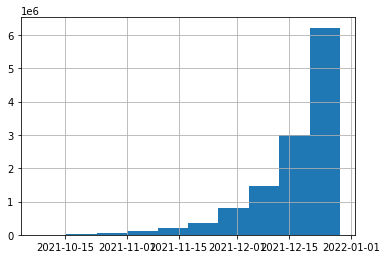

In [23]:
feed_data.timestamp.dt.date.hist()

Явный скос распределения возможно даст эффект для нашей задачи - модели будут иметь большее знание о последних днях, чем о паттернах поведения пользователей в целом.

Попробуем выгрузить данные равномерно, рискнув потерять данные о действиях каких-нибудь юзеров.

In [24]:
total_days_observed = (timestamp_limits['max'] - timestamp_limits['min']).dt.days.values[0]
print(f'Всего в базе данных записей за последние: {total_days_observed}')

Всего в базе данных записей за последние: 89


Машина, на которой планируется обучать модели выдерживает датасет около 6 миллионов строк.
Оценим "плотность взаимодействия" пользователей в нашей базе данных и максимально допустимую для расчетов.

In [25]:
feed_base_total = 77000000

print(f"Плотность взаимодействия в базе данных")
print(f"{feed_base_total // total_days_observed} действий в день")
print(f"{feed_base_total // (total_days_observed * 24)} действий в час")

Плотность взаимодействия в базе данных
865168 действий в день
36048 действий в час


Пусть для проведения синтетического A\B-теста, нам необходимо иметь данные хотя бы две недели.
Исходя из этого и ограничения на размер датасета оценим "плотность".

In [26]:
days_for_ab = 14
days_for_learn = total_days_observed - days_for_ab
max_dataset = 6000000

print(f"Максимальная плотность взаимодействия для train")
print(f"{max_dataset // days_for_learn} действий в день")
print(f"{max_dataset // (days_for_learn * 24)} действий в час")

Максимальная плотность взаимодействия для train
80000 действий в день
3333 действий в час


Попробуем получить такое распределение.

In [27]:
# Сперва рандомным семплрованием из таблицы feed_data

q = """
SELECT * 
FROM public.feed_data 
ORDER BY RANDOM()
LIMIT 6000000
"""

feed_data = select(q)
feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-27 17:59:33,78312,825,view,0
1,2021-12-13 19:03:12,167072,1254,view,0
2,2021-11-25 16:07:42,67923,6078,view,0
3,2021-12-08 14:24:08,136584,7214,like,0
4,2021-12-10 18:44:45,13846,2799,view,0


In [28]:
# Проверим разнообразие по попавшим в датасет пользователям
feed_data.nunique()

timestamp    2210281
user_id       163205
post_id         6831
action             2
target             2
dtype: int64

<AxesSubplot:>

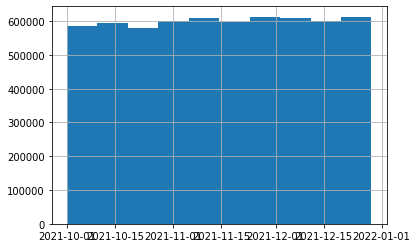

In [29]:
# Посмотрим на распределение по датам
feed_data.timestamp.dt.date.hist()

In [30]:
# Посмотрим на распределение по таргету
feed_data.target.mean()

0.10688683333333333

Распределение получилось равномерным, при этом есть действия всех пользователей.
Соотношение количества лайков к просмотрам упало на 20%, будем считать это несущественным снижением.

In [31]:
# Попробуем посмотреть сколько в базе данных всего лайков

q = """
SELECT COUNT(*)
FROM public.feed_data 
WHERE target = 1
"""

likes_only = select(q)
likes_only.head()

,count
0,8206345


<AxesSubplot:>

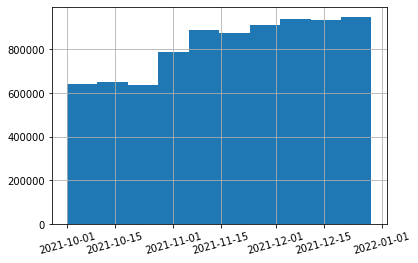

In [33]:
q = """
SELECT *
FROM public.feed_data 
WHERE target = 1
"""

likes_only = select(q)
likes_only.timestamp.dt.date.hist(xrot=15)

## Итого

Попробуем выгрузить 6кк записей, начиная с ноября - когда виден явный рост по лайкам.
При этом постараемся получить сбалансированный по таргету датасет - соотношение лайков к просмотрам примерно 1:1.

In [34]:
# Высчитаем старт теста

ab_duration = datetime.timedelta(days=13)
ab_start_date = (timestamp_limits['max'].dt.date - ab_duration).values[0]

print(f'Начало A\B-теста: {ab_start_date}')

Начало A\B-теста: 2021-12-16


In [35]:
q = """
SELECT * 
FROM public.feed_data 
WHERE target = 1 AND EXTRACT(MONTH FROM timestamp) > 10
ORDER BY RANDOM()
LIMIT 3000000
"""

feed_likes_data = select(q)
feed_likes_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-11 20:37:36,130520,5472,view,1
1,2021-12-15 15:13:15,592,1697,view,1
2,2021-11-08 13:44:38,100010,6159,view,1
3,2021-12-03 08:41:09,99414,1805,view,1
4,2021-12-19 10:44:13,90210,2540,view,1


In [36]:
q = """
SELECT * 
FROM public.feed_data 
WHERE target = 0 AND EXTRACT(MONTH FROM timestamp) > 10
ORDER BY RANDOM()
LIMIT 3000000
"""

feed_views_data = select(q)
feed_views_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-22 16:49:34,129031,2896,view,0
1,2021-12-20 19:48:17,163783,4273,view,0
2,2021-12-01 15:09:56,124496,2374,like,0
3,2021-12-15 22:46:35,58279,6471,view,0
4,2021-12-21 17:33:57,31318,5688,view,0


In [37]:
feed_data = pd.concat([feed_likes_data, feed_views_data])

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-11-11 20:37:36,130520,5472,view,1
1,2021-12-15 15:13:15,592,1697,view,1
2,2021-11-08 13:44:38,100010,6159,view,1
3,2021-12-03 08:41:09,99414,1805,view,1
4,2021-12-19 10:44:13,90210,2540,view,1


In [38]:
feed_data.shape

(6000000, 5)

In [39]:
feed_data.target.mean()

0.5

<AxesSubplot:>

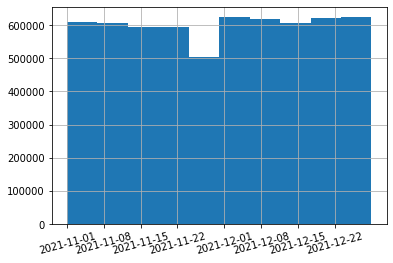

In [40]:
feed_data.timestamp.dt.date.hist(xrot=15)

In [41]:
# Проверим разнообразие по попавшим в трейн датасет пользователям
feed_data[feed_data.timestamp.dt.date < ab_start_date].nunique()

timestamp    1099361
user_id       162663
post_id         6831
action             2
target             2
dtype: int64

In [42]:
# Проверим разнообразие по попавшим в тест датасет пользователям
feed_data[feed_data.timestamp.dt.date >= ab_start_date].nunique()

timestamp    343667
user_id      142959
post_id        6831
action            2
target            2
dtype: int64

In [43]:
feed_data[feed_data.timestamp.dt.date < ab_start_date].shape

(4553539, 5)

In [44]:
feed_data[feed_data.timestamp.dt.date < ab_start_date].target.mean()

0.497670273604772

In [45]:
feed_data[feed_data.timestamp.dt.date >= ab_start_date].target.mean()

0.5073341071760663

Остановимся на этом, будем использовать получившийся датасет в дальнейшей работе.